In [1]:
## import kagglehub
# Download latest version
## path = kagglehub.dataset_download("nicolasgonzalezmunoz/earthquakes-on-chile")
## print("Path to dataset files:", path)

In [2]:
"""
import pandas as pd
import os

# First split the data into multiple files of 500 rows cause geopandas is a bad
# library and cant do reverse geocoding. >:(

def split_csv_in_batches(input_csv_path, batch_size=500, output_dir="output_batches"):
    # Splits a CSV file into multiple smaller CSV files, each containing a specified number of rows.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Read the CSV file in chunks
    chunk_iterator = pd.read_csv(input_csv_path, chunksize=batch_size)

    file_count = 1
    for chunk in chunk_iterator:
        output_file_name = f"batch_{file_count:04d}.csv"
        output_file_path = os.path.join(output_dir, output_file_name)
        chunk.to_csv(output_file_path, index=False)
        print(f"Created {output_file_path}")
        file_count += 1

# Example usage:
split_csv_in_batches("seismic_data.csv", batch_size=500, output_dir="split_data")


# The third party I used is https://www.geoapify.com/tools/reverse-geocoding-online/
"""

'\nimport pandas as pd\nimport os\n\n# First split the data into multiple files of 500 rows cause geopandas is a bad\n# library and cant do reverse geocoding. >:(\n\ndef split_csv_in_batches(input_csv_path, batch_size=500, output_dir="output_batches"):\n    # Splits a CSV file into multiple smaller CSV files, each containing a specified number of rows.\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n    # Read the CSV file in chunks\n    chunk_iterator = pd.read_csv(input_csv_path, chunksize=batch_size)\n\n    file_count = 1\n    for chunk in chunk_iterator:\n        output_file_name = f"batch_{file_count:04d}.csv"\n        output_file_path = os.path.join(output_dir, output_file_name)\n        chunk.to_csv(output_file_path, index=False)\n        print(f"Created {output_file_path}")\n        file_count += 1\n\n# Example usage:\nsplit_csv_in_batches("seismic_data.csv", batch_size=500, output_dir="split_data")\n\n\n# The third party I used is https://www.geoapify

In [3]:
"""
import pandas as pd
from glob import glob

folder_path = 'reversed_data'  # Replace with your folder's path
file_pattern = '*.csv'  # Or '*.xlsx' for Excel files
all_files = glob(f"{folder_path}/{file_pattern}")
dfs = []
for file in all_files:
    if file_pattern.endswith('.csv'):
        df = pd.read_csv(file)
    # Add more conditions for other file types if needed
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)
# Keep just the necessary columns
merged_df = merged_df[['original_Date(UTC)', 'original_Latitude', 'original_Longitude',
           'original_Depth', 'original_Magnitude', 'city'
           ]]
merged_df.to_csv("Temp1.csv", index=False)
"""

'\nimport pandas as pd\nfrom glob import glob\n\nfolder_path = \'reversed_data\'  # Replace with your folder\'s path\nfile_pattern = \'*.csv\'  # Or \'*.xlsx\' for Excel files\nall_files = glob(f"{folder_path}/{file_pattern}")\ndfs = []\nfor file in all_files:\n    if file_pattern.endswith(\'.csv\'):\n        df = pd.read_csv(file)\n    # Add more conditions for other file types if needed\n    dfs.append(df)\nmerged_df = pd.concat(dfs, ignore_index=True)\n# Keep just the necessary columns\nmerged_df = merged_df[[\'original_Date(UTC)\', \'original_Latitude\', \'original_Longitude\',\n           \'original_Depth\', \'original_Magnitude\', \'city\'\n           ]]\nmerged_df.to_csv("Temp1.csv", index=False)\n'

In [4]:
"""
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import matplotlib.pyplot as plt
from datetime import timedelta
from shapely.geometry import Polygon

# Read the data sources
df = pd.read_csv("Temp1.csv")
tectonic = pd.read_csv("tectonic_plates.csv")

# Rename the main variables to use in our main dataset
df.columns = ['Date', 'Latitude', 'Longitude', 'Depth', 
              'Magnitude', 'City']

#Load a map of the earth
world = gpd.read_file(get_path("naturalearth.land"))

# Turn the coordinates of the tectonic plates into Geopanda Points
tectonic['Geometry'] = gpd.points_from_xy(tectonic.lon, tectonic.lat)
# Turn the coordinates of the earthquakes into Geopanda Points
df['Geometry'] = gpd.points_from_xy(df.Longitude, df.Latitude)

# Create a loop to create polygons for each tectonic plate
# And also determines to which tectonic plate each earthquake belongs to
tectonic["Polygon_plate"] = ""
df['Name_Plate'] = ""
for i in tectonic.plate.unique():
    df_1 = tectonic[tectonic.plate == i]
    # Define the polygon boundary for each tectonic plate
    polygon = Polygon(zip(df_1.lon.tolist(), df_1.lat.tolist()))
    tectonic[tectonic.plate == i]["Polygon_plate"] = polygon
    for x in range(df.shape[0]):
        if df.loc[x, 'Name_Plate'] == "":
            # Check if the polygon contains the points
            if polygon.contains(df['Geometry'][x]):
                df.loc[x, 'Name_Plate'] = i
                df.loc[x, 'Polygon_plate'] = polygon
        else:
            pass

# Turn the date column into datetime format
df.Date = pd.to_datetime(df.Date)
# Sort by 'Age' in ascending order
df = df.sort_values(by='Date')
# Extract year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

# Fill NaT with timedelta(0) and get total minutes
dfs = []
df["Hours between earthquakes"] = ""
for i in df.Name_Plate.unique():
    df_2 = df[df["Name_Plate"]==i]
    df_2['Hours between earthquakes'] = df_2['Date'].diff().fillna(timedelta(0)).apply(lambda x: x.total_seconds() / 3600)
    # Add more conditions for other file types if needed
    dfs.append(df_2)
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv("Temp2.csv", index=False)
"""

'\nimport pandas as pd\nimport geopandas as gpd\nfrom geodatasets import get_path\nimport matplotlib.pyplot as plt\nfrom datetime import timedelta\nfrom shapely.geometry import Polygon\n\n# Read the data sources\ndf = pd.read_csv("Temp1.csv")\ntectonic = pd.read_csv("tectonic_plates.csv")\n\n# Rename the main variables to use in our main dataset\ndf.columns = [\'Date\', \'Latitude\', \'Longitude\', \'Depth\', \n              \'Magnitude\', \'City\']\n\n#Load a map of the earth\nworld = gpd.read_file(get_path("naturalearth.land"))\n\n# Turn the coordinates of the tectonic plates into Geopanda Points\ntectonic[\'Geometry\'] = gpd.points_from_xy(tectonic.lon, tectonic.lat)\n# Turn the coordinates of the earthquakes into Geopanda Points\ndf[\'Geometry\'] = gpd.points_from_xy(df.Longitude, df.Latitude)\n\n# Create a loop to create polygons for each tectonic plate\n# And also determines to which tectonic plate each earthquake belongs to\ntectonic["Polygon_plate"] = ""\ndf[\'Name_Plate\'] = "

In [5]:
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import matplotlib.pyplot as plt
from datetime import timedelta
from shapely.geometry import Polygon

merged_df=pd.read_csv("Temp2.csv")
merged_df["Date"] = pd.to_datetime(merged_df["Date"])
merged_df["Date"] = merged_df["Date"].dt.date
merged_df = merged_df.dropna(subset=["City"])
merged_df = merged_df[['Date', 'City', 'Latitude', 'Longitude', 
                       'Magnitude', 'Geometry', 'Name_Plate', 'Polygon_plate',]]
# Group by 'Date' and 'City', then join the 'Magnitude',  values
#df_combined = merged_df.groupby(['Date', 'City'])['Magnitude'].apply(lambda x: ', '.join(str(x))).reset_index()
# Example: sum of magnitudes
df_combined1 = merged_df.groupby(['Date', 'Name_Plate'], as_index=False)['Magnitude'].mean()
df_combined2 = merged_df.groupby(['Date', 'Name_Plate'], as_index=False)['Magnitude'].count()
df_2 = pd.merge(df_combined2, df_combined1, how = "left", on = ['Date', 'Name_Plate'])
df_2 = pd.merge(df_2, merged_df, how = "left", on = ['Date', 'Name_Plate'])
df_2.columns = ['Date', 'Name_Plate', 'Count_Quakes', 
                'Magnitude_Mean', 'City', 'Latitude', 'Longitude', 'Magnitude',
                'Geometry', 'Polygon_plate',]
df_dictionary = df_2[['City', 'Latitude', 'Longitude', 
        'Geometry', 'Name_Plate', 'Polygon_plate']].drop_duplicates(subset='Name_Plate', keep='first')

In [6]:
# Not shown here, but I did try to fit the model to
# A random forest regressor, linear regression and 
# to an exponential distribution
# For the random forests I got the following results:
# Squared Error: 6456.824756448705
# Squared Error: 15165.083872640633
# Squared Error: 38848.87231248201
# Squared Error: 282088.9955848992
# Squared Error: 568939983.2155479

# None of the models worked so I switched to time series:

In [7]:
import pandas as pd

start = "2012-01-01"
end = "2025-12-31"
dfs = []
for i in merged_df["Name_Plate"].unique():
    df = pd.DataFrame({"Date": pd.date_range(start=start, end=end)})
    df["Name_Plate"] = i
    dfs.append(df)
new_df = pd.concat(dfs, ignore_index=True)

In [8]:
df_2["Date"] = pd.to_datetime(df_2["Date"]).dt.date   # makes it `object` with date
new_df["Date"] = pd.to_datetime(new_df["Date"]).dt.date
new_df = new_df.merge(df_2[["Date", "Name_Plate", "Count_Quakes", "Magnitude_Mean"]], how="left", on=["Date", "Name_Plate"])
new_df = new_df.fillna(0)

In [9]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
# Extract year and month
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2['Year'] = df_2['Date'].dt.year
df_2['Month'] = df_2['Date'].dt.month
df_2['Day'] = df_2['Date'].dt.day
df_2['Hour'] = df_2['Date'].dt.hour
df_2['Minute'] = df_2['Date'].dt.minute

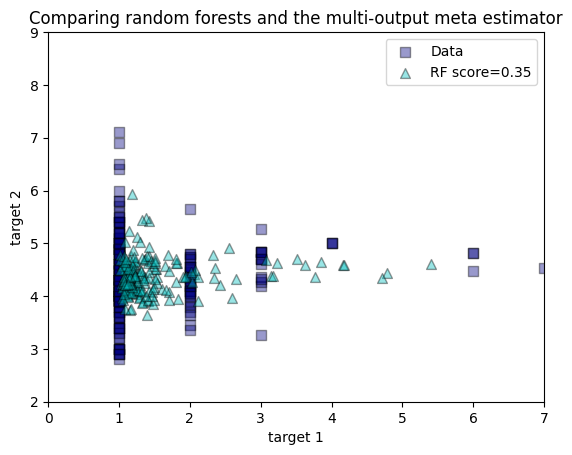

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

# Create a random dataset
X = df_2[['Latitude', 'Longitude', 'Year', 'Month', 'Day']]
y = df_2[['Count_Quakes', 'Magnitude_Mean']]
#y += 0.5 - rng.rand(*y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=400, test_size=200, random_state=4
)

max_depth = 30
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(
    y_test.iloc[:, 0],
    y_test.iloc[:, 1],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label="Data",
)
plt.scatter(
    y_rf[:, 0],
    y_rf[:, 1],
    edgecolor="k",
    c="c",
    s=s,
    marker="^",
    alpha=a,
    label="RF score=%.2f" % regr_rf.score(X_test, y_test),
)
plt.xlim([0, 7])
plt.ylim([2, 9])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [11]:
import pandas as pd
from datetime import date

start = date.today()
# Add one week using timedelta
end = start + timedelta(weeks=1)

dfs = []
for i in df_2["Name_Plate"].unique():
    df = pd.DataFrame({"Date": pd.date_range(start=start, end=end)})
    df[['Name_Plate', 'City','Latitude', 
          'Longitude', 'Geometry', 'Polygon_plate']] = df_2[df_2.Name_Plate == i].reset_index(drop=True).loc[:7,['Name_Plate', 'City',
       'Latitude', 'Longitude', 'Geometry', 'Polygon_plate']]
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour
    df['Minute'] = df['Date'].dt.minute     
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)

In [ ]:
# Create a random dataset
X_1 = merged_df[['Latitude', 'Longitude', 'Year', 'Month', 'Day']]
# y = df_2[['Count_Quakes', 'Magnitude_Mean']]
# Predict on new data
y_1 = regr_rf.predict(X_1)
merged_df[['Count_Quakes', 'Magnitude_Mean']] = y_1
merged_df['IsPrediction']="royalblue"
df_2['IsPrediction']="red"
merged_df.to_csv("Temp3.csv", index=False)

In [ ]:
end_df = pd.concat([df_2[['Date', 'Name_Plate', 'City', 'Latitude', 'Longitude', 'Geometry',
       'Polygon_plate', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Count_Quakes', 'Magnitude_Mean', 'IsPrediction']],merged_df])
end_df.to_csv("Result.csv", index=False)

In [15]:
end_df.IsPrediction.unique()

array([nan, 'royalblue'], dtype=object)

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.read_csv('Result.csv')
#scale = 2
df['text'] = 'Ciudad: ' + df['City'] + ',\n Number of Quakes: ' + (df['Count_Quakes']).astype(str) + ',\n Magnitude of Quakes: ' + (df['Magnitude_Mean']).astype(str)
# Assuming df has columns: Longitude, Latitude
fig = px.scatter_geo(df,
    lon="Longitude",
    lat="Latitude",
    scope="south america",  # sets projection region
    projection="natural earth",
    hover_data={'Longitude':False,'Latitude':False,'text':True}
)
# Style the markers
fig.update_traces(
    marker=dict(size=df['Magnitude_Mean'], color=df["IsPrediction"], 
                opacity=0.7, line=dict(width=0.5, color="gray"))
)

# Map aesthetics
fig.update_geos(
    showcountries=True, countrycolor="gray",
    showland=True, landcolor="lightgray",
    showocean=True, oceancolor="lightblue",
    showcoastlines=True, coastlinecolor="darkgray",
    lataxis=dict(range=[-55, 15]),
    lonaxis=dict(range=[-90, -25]),
)

# Layout polish
fig.update_layout(
    title=dict(
        text="Chilean Earthquakes",
        x=0.5, xanchor="center",
        font=dict(size=20)
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    height=600,
    template="plotly_white"
)

fig.show()